# Lab 08 - Relational Data and Strings



In [ ]:
install.packages("sqldf") # run these if using Colab
install.packages("nycflights13")

In [ ]:
library(tidyverse)
library(nycflights13)
library(sqldf)

In [ ]:
# load the data
# source: https://www.kaggle.com/manjeetsingh/retaildataset
features <- read_csv("https://raw.githubusercontent.com/bmanzo/stats306_labs/master/lab07/features.csv")
sales <- read_csv("https://raw.githubusercontent.com/bmanzo/stats306_labs/master/lab07/sales.csv")
stores <- read_csv("https://raw.githubusercontent.com/bmanzo/stats306_labs/master/lab07/stores.csv")

### More joins

Last week's lab gave examples of `left_join`. Another common join is the `inner_join`, which only includes observations associated to keys that are in both tables. 

In [ ]:
x <- tribble(
  ~key, ~val_x,
     1, "x1",
     2, "x2",
     3, "x3"
)
y <- tribble(
  ~key, ~val_y,
     1, "y1",
     2, "y2",
     4, "y3"
)
inner_join(x, y)

This data includes historical sales for a number of large stores, and first we'll need to join the store level data to the individual sales level data. We'll use an inner join to add the `stores` data to the `sales` data, then we'll use a left join to add the `features` data, which includes more specific details about the store and the date of the sale. 

In [ ]:
head(stores)

In [ ]:
head(sales)

In [ ]:
head(features)

In [ ]:
sales_stores = inner_join(sales, stores, by="Store")
head(sales_stores)

In [ ]:
full_data = left_join(sales_stores, features, by=c("Store", "Date", "IsHoliday"))

In [ ]:
head(full_data)

In [ ]:
summary(full_data)

In [ ]:
# we need to adjust some of the variable types
full_data$Store = as.factor(full_data$Store)
full_data$Dept = as.factor(full_data$Dept)
full_data$Type = as.factor(full_data$Type)

We also need to adjust the date - how should we do that? 

In [ ]:
head(full_data$Date)

In [ ]:
full_data$Date = as.Date(full_data$Date, format = "%d / %m / %Y")
head(full_data$Date)
class(full_data$Date)

Here we attach a table of date formats:

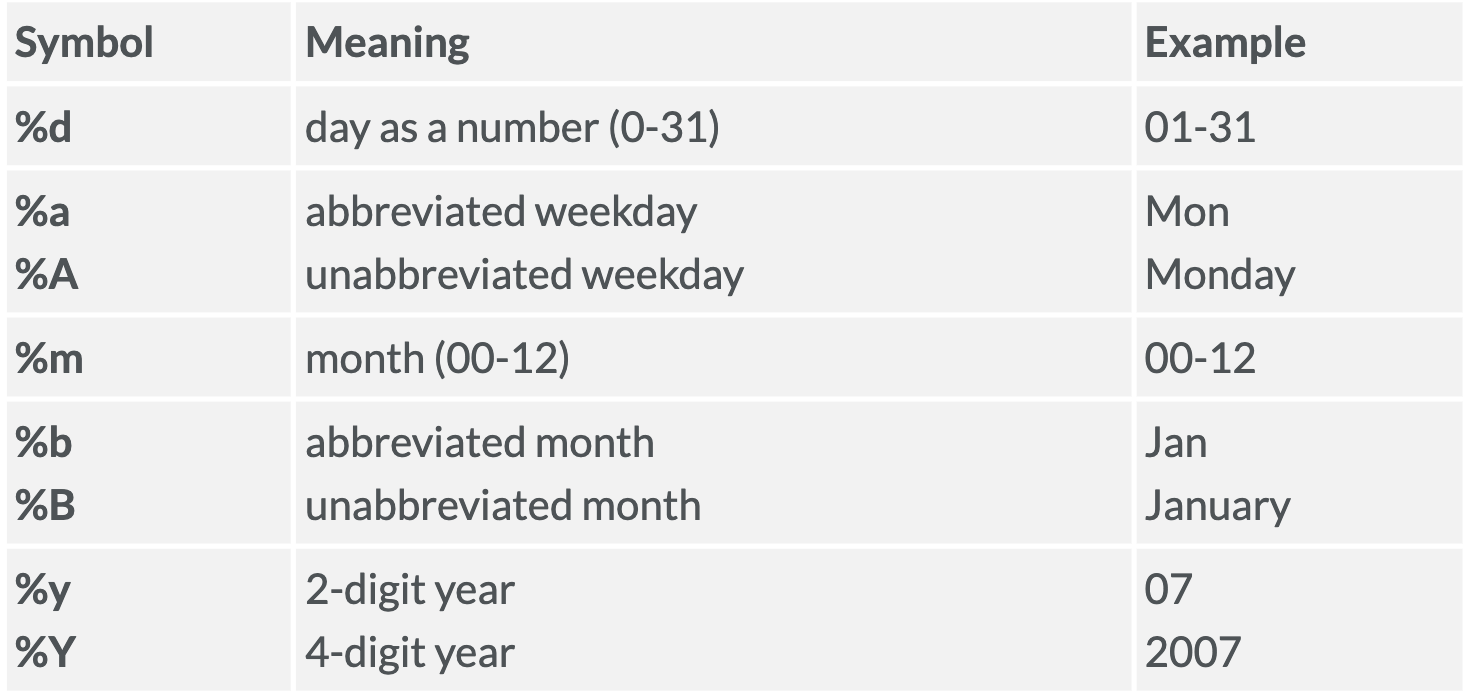

source from: https://www.statmethods.net/input/dates.html

In [ ]:
summary(full_data) # everything looks good now

**Exercise:** Perform the same join using SQL

Hint: use this syntax

{sql}
SELECT * FROM <table> LEFT JOIN <other_table> ON <left_key_col> = <right_key_col>

In [ ]:
sqltbl <- function(...) sqldf(...) 

Other types of joins covered in lecture include the semi join and the anti join. We'll briefly look at some examples here.

### Semi-join
`semi_join(x, y)` keeps all the observations in `x` that are also in `y`.
![semi join](http://r4ds.had.co.nz/diagrams/join-semi.png)

### Anti-join
The opposite of a semi-join is an anti-join:
![anti-join](http://r4ds.had.co.nz/diagrams/join-anti.png)

If you are really afraid of flying, you might not want to fly on old planes. How can you use anti join to find the flights that took place on planes <5 years old?

In [ ]:
head(planes)

In [ ]:
plane_ages = mutate(planes, age = 2013 - year)
old_planes = plane_ages %>% filter(age >= 5)
safe_flights = anti_join(flights, old_planes, by="tailnum") 
head(safe_flights, 3) 
planes[which(planes$tailnum=="N39463"),]

In [ ]:
old_flights = semi_join(flights, old_planes, by="tailnum")
dim(old_flights)[1]
dim(safe_flights)[1]
dim(flights)[1]
dim(old_flights)[1] + dim(safe_flights)[1]

We can see above that the anti join is the opposite of the semi join

### SQL commands and `dplyr`

Note: we will not cover this in class but you may find [`dbplyr`](https://dbplyr.tidyverse.org/) useful. This package converts `dplyr` code (e.g., `filter` and `summarise`) to SQL commands. 

A simple question to ask is which store has the highest average weekly sales during holidays. We can use `dplyr` commands for this

In [ ]:
full_data %>% 
    filter(IsHoliday==TRUE) %>% 
    group_by(Store) %>% 
    summarise(avg_sales = mean(Weekly_Sales), count=n()) %>% 
    arrange(desc(avg_sales)) %>% 
    head(5)

**Exercise:** create the same table using SQL commands

## Text analysis with Animal Crossing reviews

We'll try to learn some things about Animal Crossing by looking at user reviews. ([source](https://www.kaggle.com/jessemostipak/animal-crossing))

In [ ]:
reviews = read_csv("https://raw.githubusercontent.com/bmanzo/stats306_labs/master/lab07/user_reviews.csv")
head(reviews)

We'll ignore 0 star reviews as these are probably not as informative

In [ ]:
reviews_clean = reviews %>% filter(grade > 0)
head(reviews_clean)

A lot of people are complaining about the inability of more than one person to play on the same console. What are some ways to quantify this?

In [ ]:
str_count(reviews_clean$text, "2") %>% head()
mean(str_count(reviews_clean$text, "2") >0)
str_count(reviews_clean$text, "second") %>% head()
mean(str_count(reviews_clean$text, "second") >0)

What do people who really like the game say about it? 

In [ ]:
big_fans = filter(reviews_clean, between(grade, 8, 10))
tail(big_fans, 4)

In [ ]:
big_fans[which(str_count(big_fans$text, "favorite")>0),]

**Exercise:** Some reviews in the dataset are incomplete (i.e., they end with "Expand"). How many of those are there?

**Exercise:** Is there a correlation between the length of a review and the grade the reviewer gives? Justify your answer with some kind of plot.

**Hint**: we can use the # of spaces as a proxy for # of words

In [ ]:
# we'll use the # of spaces as a proxy for # of words
